In [13]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#SKLearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from urllib.parse import quote_plus
import sqlalchemy

from pathlib import Path
cwd = Path.cwd()
data_path = cwd.parents[0] / 'data'

params = quote_plus(
    """DRIVER={ODBC Driver 13 for SQL Server};SERVER=server-dw01.database.windows.net;DATABASE=DataWarehouseStaging;UID=dw_userlogin;PWD=kljDueK!7"""
)

ENGINE = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)


def dwhQuery(sqlQuery):
    """
    Wrapper for turning SQL query to DWH
    into a pandas dataframe
    :param sqlQuery: SQL query to be processed
    :return: SQL query as a pandas DataFrame
    """
    return pd.read_sql(sql=sqlQuery, con=ENGINE)


In [2]:
df = dwhQuery('''SELECT * FROM pam.mcc_sic_dict''')

In [3]:
df.to_csv('df.csv', index=False)

In [7]:
opp_df = dwhQuery('''SELECT w.[Opportunity ID]
	,[MCC_Description] AS [MCC_DESC]
	,[Industry_Corrected]
    ,[Contract Start Date]
    ,c.[Purchased Amount]
	,[Written Off]
	,[Date Written Off]
    ,[Amount at Write Off]

FROM [marketing].[WP_Attri_Mailers] AS w

LEFT JOIN Opportunities AS o
	ON o.[Opportunity ID] = w.[Opportunity ID]

INNER JOIN Contracts AS c
	ON o.[Opportunity ID] = c.[Original Opportunity ID]

WHERE w.[Opportunity ID] IS NOT NULL
	AND MCC_Description IS NOT NULL

''')

In [8]:
opp_df.to_csv('opp_df.csv', index=False)

In [9]:
desc = list(df['desc'])
desc_list = [i.lower() for i in desc if pd.notnull(i)]

In [10]:
from gensim.utils import simple_preprocess

mcc_tokens = [gensim.utils.simple_preprocess(i) for i in desc_list]

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['pc', 'crd', 'card', 're', 'ag', 'non'])

mcc_tokens_nostop = [[token for token in doc if token not in stop_words] for doc in mcc_tokens]

In [14]:
mcc_fix = pd.read_csv(data_path / 'mcc_corrections.csv')
mcc_fix = mcc_fix.fillna('')
mcc_dict = pd.Series(mcc_fix['new'].values, index=mcc_fix['old']).to_dict()    

In [15]:
for i, doc in enumerate(mcc_tokens_nostop):
    for j,token in enumerate(doc):
        if token in mcc_dict.keys():
            mcc_tokens_nostop[i][j] = mcc_dict[token]

In [16]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
mcc_tokens_lemmad = [[lemmatizer.lemmatize(token) for token in doc] for doc in mcc_tokens_nostop]

In [17]:
doc_list = [' '.join(doc) for doc in mcc_tokens_lemmad]

In [18]:
id2word = corpora.Dictionary(mcc_tokens_lemmad)
texts = mcc_tokens_lemmad

corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
from gensim.models.ldamodel import LdaModel
lda_model = LdaModel(corpus, id2word = id2word, num_topics = 5, alpha = 'auto', random_state = 42,
                    update_every = 1, chunksize = 100, passes = 20, eta = 0.1)

In [46]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [47]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"fire" + 0.007*"plastic" + 0.006*"horn" + 0.006*"nib" + '
  '0.006*"resistant" + 0.006*"coffin" + 0.006*"ivory" + 0.006*"refill" + '
  '0.006*"protective" + 0.006*"protection"'),
 (1,
  '0.006*"service" + 0.006*"food" + 0.006*"store" + 0.005*"vehicle" + '
  '0.005*"retail" + 0.005*"sale" + 0.005*"agent" + 0.005*"accessory" + '
  '0.004*"good" + 0.004*"auction"'),
 (2,
  '0.005*"stamp" + 0.004*"metal" + 0.004*"wood" + 0.004*"gas" + 0.004*"coin" + '
  '0.004*"building" + 0.003*"domestic" + 0.003*"material" + 0.003*"retail" + '
  '0.003*"oil"'),
 (3,
  '0.010*"service" + 0.006*"coin" + 0.006*"artist" + 0.006*"porter" + '
  '0.005*"operated" + 0.005*"machine" + 0.005*"agency" + 0.004*"computer" + '
  '0.004*"home" + 0.004*"animal"'),
 (4,
  '0.007*"recreational" + 0.006*"park" + 0.006*"sport" + 0.006*"show" + '
  '0.006*"ground" + 0.006*"service" + 0.006*"local" + 0.005*"hill" + '
  '0.005*"coin" + 0.005*"racehorse"')]


In [48]:
df_dominant_topic['MCC_DESC'] = df['MCC_DESC']

In [49]:
result_df = opp_df.merge(df_dominant_topic, how = 'left', on = 'MCC_DESC')

In [50]:
dict_df = result_df[['MCC_DESC', 'Dominant_Topic']].drop_duplicates()

In [51]:
from fast_to_SQL.fast_to_SQL import to_sql_fast
to_sql_fast(dict_df, name = 'pam.MCC_cluster_dict', engine = ENGINE, if_exists = 'replace')

In [27]:
result_df.to_csv('result_df.csv', index = False)

In [44]:
result_df[['Dominant_Topic', 'Written Off']].groupby('Dominant_Topic').agg(['count', 'mean']).sort_values(('Written Off', 'count'), ascending = False)

Written Off          
                     count      mean
Dominant_Topic                      
1.0                   3376  0.089751
0.0                   1003  0.068794
2.0                    738  0.104336

In [29]:
from statsmodels.stats.weightstats import ztest

In [30]:
result_df[result_df['Dominant_Topic'] == 0]['Written Off']

58      0
79      0
85      0
188     0
195     0
       ..
5014    0
5024    0
5048    0
5099    0
5111    0
Name: Written Off, Length: 227, dtype: int64

In [31]:
ztest(x1 = result_df[result_df['Dominant_Topic'] == 0]['Written Off'], x2 = result_df[result_df['Dominant_Topic'] == 2]['Written Off'])

(0.31675819987335563, 0.7514270837685667)

In [32]:
import itertools
n = 3

test_list = list(itertools.combinations(range(n), 2))

lda_model = LdaModel(corpus, id2word = id2word, num_topics = n, alpha = 'auto', random_state = 42,
                    update_every = 1, chunksize = 100, passes = 20, eta = 0.1)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['MCC_DESC'] = df['MCC_DESC']

result_df = opp_df.merge(df_dominant_topic, how = 'left', on = 'MCC_DESC')
count = 0
for i1, i2 in test_list:
    tstat, pvalue = ztest(x1 = result_df[result_df['Dominant_Topic'] == i1]['Written Off'],
                          x2 = result_df[result_df['Dominant_Topic'] == i2]['Written Off'])
    print(pvalue)
    if pvalue < 0.05:
        count += 1
count

0.0365442995547576
0.008100686038186988
0.21514580157689134


2

In [261]:
n_list = []
count_list = []
for n in range(1, 20, 2):
    test_list = list(itertools.combinations(range(n), 2))

    lda_model = LdaModel(corpus, id2word = id2word, num_topics = n, alpha = 'auto', random_state = 42,
                        update_every = 1, chunksize = 100, passes = 20, eta = 0.1)

    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic['MCC_DESC'] = df['MCC_DESC']

    result_df = opp_df.merge(df_dominant_topic, how = 'left', on = 'MCC_DESC')
    count = 0
    for i1, i2 in test_list:
        if (result_df[result_df['Dominant_Topic'] == i1].empty) or (result_df[result_df['Dominant_Topic'] == i2].empty):
            continue
        tstat, pvalue = ztest(x1 = result_df[result_df['Dominant_Topic'] == i1]['Written Off'],
                              x2 = result_df[result_df['Dominant_Topic'] == i2]['Written Off'])
        if pvalue < 0.05:
            count += 1
    n_list.append(n)
    count_list.append(count)

c:\users\ryan.skeels\appdata\local\continuum\anaconda2\envs\py36_pam\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff
c:\users\ryan.skeels\appdata\local\continuum\anaconda2\envs\py36_pam\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\ryan.skeels\appdata\local\continuum\anaconda2\envs\py36_pam\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\ryan.skeels\appdata\local\continuum\anaconda2\envs\py36_pam\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


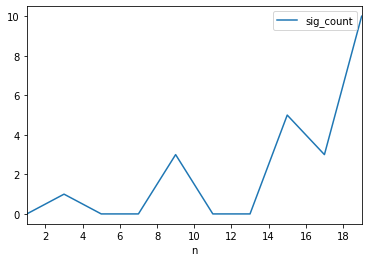

In [262]:
graph_df = pd.DataFrame(data = {'n':n_list, 'sig_count':count_list})

graph_df.set_index(['n']).plot()

In [270]:
n=9
test_list = list(itertools.combinations(range(n), 2))

lda_model = LdaModel(corpus, id2word = id2word, num_topics = n, alpha = 'auto', random_state = 42,
                    update_every = 1, chunksize = 100, passes = 20, eta = 0.1)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['MCC_DESC'] = df['MCC_DESC']

result_df = opp_df.merge(df_dominant_topic, how = 'left', on = 'MCC_DESC')
count = 0
for i1, i2 in test_list:
    if (result_df[result_df['Dominant_Topic'] == i1].empty) or (result_df[result_df['Dominant_Topic'] == i2].empty):
        continue
    tstat, pvalue = ztest(x1 = result_df[result_df['Dominant_Topic'] == i1]['Written Off'],
                          x2 = result_df[result_df['Dominant_Topic'] == i2]['Written Off'])
    if pvalue < 0.05:
        count += 1
        print(f'pvalue = {pvalue}')
        print(result_df[result_df['Dominant_Topic'] == i1]['Written Off'].mean())
        print(result_df[result_df['Dominant_Topic'] == i2]['Written Off'].mean())

pvalue = 0.038835517648506256
0.08994413407821229
0.06583850931677018
pvalue = 0.04301018022683451
0.06583850931677018
0.09921671018276762
pvalue = 0.025894511457175237
0.06583850931677018
0.12195121951219512


In [33]:
result_df[['Dominant_Topic', 'Written Off']].groupby('Dominant_Topic').agg(['count', 'mean']).sort_values(('Written Off', 'mean'), ascending = False)

Written Off          
                     count      mean
Dominant_Topic                      
2.0                    738  0.104336
1.0                   3376  0.089751
0.0                   1003  0.068794

In [276]:
result_df[result_df['Dominant_Topic'] == 4][['MCC_DESC', 'Topic_Perc_Contrib']].drop_duplicates()

,MCC_DESC,Topic_Perc_Contrib
2,PROFESSIONAL SERVICES,0.7714
17,COSMETIC STORES,0.4135
21,SCHOOLS & EDUCATIONAL SERVICES,0.4187
30,OPTICIANS,0.4751
35,DENTISTS ORTHODONTISTS,0.9902
38,MISCELLANEOUS PERSONAL SERVICE,0.2927
40,BARBER & BEAUTY SHOPS,0.6649
76,LAB/DENT/OPTH-HOSP EQPT/SUP(PC,0.7553
84,MEDICAL SERVICES MISC,0.7936
94,BUSINESS SERVICES MISC,0.3596


In [274]:
result_df

,Opportunity ID,MCC_DESC,Industry_Corrected,Contract Start Date,Purchased Amount,Written Off,Date Written Off,Amount at Write Off,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0062X00000tfbHfQAI,HOTELS MOTELS & RESORTS-LODGIN,Hotel / B&B,2018-04-16,19800.0,0,NaT,0.0,103.0,2.0,0.4430,"park, garden, hill, ski, show, coin, hall, gas...","[hotel, motel, resort, lodging, restaurant, pr..."
1,0062X00000tfcWgQAI,FLOOR COVERING STORES,Other Services,2018-04-16,28250.0,0,NaT,0.0,77.0,5.0,0.5384,"building, metal, tool, door, wood, manufacture...","[floor, covering, store, imprinting, real, tim..."
2,0062X00000tfdxJQAQ,PROFESSIONAL SERVICES,Other Retailer,2018-04-12,9310.0,0,NaT,0.0,152.0,3.0,0.7714,"service, centre, medical, private, health, con...","[professional, service, private, ester, servic..."
3,0062X00000tff0TQAQ,MISCELLANEOUS FOOD STORES,Food / Drink Shop,2018-04-12,19800.0,0,NaT,0.0,124.0,1.0,0.5098,"store, retail, food, good, sale, made, woman, ...","[miscellaneous, food, store, restaurant, instr..."
4,0062X00000tfiHaQAI,COMPUTER MAINT/REPR-UNCLASS(PC,Other Services,2018-04-12,5360.0,0,NaT,0.0,44.0,7.0,0.6773,"service, computer, radio, cd, dvd, equipment, ...","[computer, maintenance, repair, unclassified, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4652,006w000000teAKWAA2,BUSINESS SERVICES MISC,Other Services,2017-12-07,6700.0,0,NaT,0.0,27.0,3.0,0.3596,"service, centre, medical, private, health, con...","[business, service, miscellaneous, butt, cante..."
4653,006w000000teAnYAAU,HOTELS MOTELS & RESORTS-LODGIN,Hotel / B&B,2017-12-05,5494.0,0,NaT,0.0,103.0,2.0,0.4430,"park, garden, hill, ski, show, coin, hall, gas...","[hotel, motel, resort, lodging, restaurant, pr..."
4654,006w000000teAtCAAU,MISC PUBLISH/PRINTING (P.CARD),Other Services,2017-12-07,18620.0,0,NaT,0.0,122.0,1.0,0.3216,"store, retail, food, good, sale, made, woman, ...","[miscellaneous, publish, printing, instrument,..."
4655,006w000000teClZAAU,EXPRESS PAYMNT SRVCE FAST FOOD,Other Services,2017-12-27,18620.0,0,NaT,0.0,73.0,1.0,0.3682,"store, retail, food, good, sale, made, woman, ...","[express, payment, service, fast, food, restau..."
